## U.S. Patent Phrase to Phrase Matching
* [Data](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)
   - Don Cenkci, Grigor Aslanyan, Ian Wetherbee, jm, Kiran Gunda, Maggie, Scott Beliveau, Will Cukierski. (2022). U.S. Patent Phrase to Phrase Matching. Kaggle. 
 
## Problem Statement and Objective
The objective is to predict the Pearson similarity score, a number between 0 and 1, between phrases extracted from US Patents.
This is a regression problem.
The data also includes the context in which the phrases are to be understood: the first two levels of the [CPC Classification](https://en.wikipedia.org/wiki/Cooperative_Patent_Classification).

## Methodology
Clean up the data, then convert to numerical values, then train a suitable ML model.
Not too much cleaning seems to be required on the phrases themselves, they are already converted to lower case,
don't seem to have contractions, etc.  Will apply some cleanup just in case, but does not seem to be strictly necessary.
We will however remove "stop" words.

Next, we need to convert the phrases into numerical form.   We will convert each phrase into a vector representing
the meanings in the sentences.  The phrases are quite short generally, just a few words, so need to pick an approach suitable 
for that kind of data.   We chose word2vec since it does not require a large corpus to compute frequencies.  On the other hand,
it may not interpret technical terms in the same way as they are used in patents, and will not be conditioned by the CPC
categories.  Ideally we would use the corpus the patents in each category to create embeddings but this is not feasible, so
we will use the word2vec embedding.   Since the cosine similarity of phrases is computed with a dot product between two word
vectors, we will use the pairwise products of the two word vectors as a feature vector input to our model, as well as the cosine
similarity.  Use of the pairwise products will allow a suitable model to learn a weighting of the various elements of the 
vectors suitable for each category.   Including the cosine similarity as a baseline will allow us to build models that can
learn only the residuals conditioned by the categories.  However, while we plan to build a custom model that can take advantage
of this structure, we are also going to try a few other "typical" models for comparison: SVR, random forests, and so on.

The other issue is the CPC category.   There are a lot of CPC categories (over 100 appear in the data), but we decided to use
a one-hot encoding regardless, since this will make "gating" by particular categories easier.
We did not try to break the categories into primary and secondary categories however to avoid spurious matches based on similar
secondary categories with different primary categories.  That is, we don't want A45 and B45 to be treated as similar because the
meaning of "45" is completely different in the A and B primary categories.

For the ML model training, we will try a set of different models and use hyperparameter training to try and find the best
approach.   The best models on the leaderboard seem to have R2 scores in the 0.8 to 0.9 range.

As a note the training data seems to have scores drawn from a small set of possible values: 0, 0.25, 0.5, 0.75, and 1, but this is likely
just an artifact of manual scoring.  We will assume continuous scores in the range 0 to 1 inclusive are acceptable.  However, this
does complicate evaluation of our model, since there will be spurious errors when comparing continuous outputs from our model 
with the test data, e.g. if our model outputs 0.8 and the test data says 0.75, there is an "error" of 0.05 but this is actually
quantization noise in the test data.
Therefore, we will compute errors against both the continuous output from the model and a "quantized" output.

## Libraries

In [1]:
# Only need to run these once
# !python -m pip install tqdm
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !python -m spacy download en_core_web_lg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

The following defines a function that uses the SpaCy `en_core_web_lg` model it to compute a vector
representing all the words in a document.   The "documents" here will be single phrases.

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return np.array(vec)

## Data

| Label       | Meaning                       | Values                                                                                  |
| ----------- | ----------------------------- | ----------------------------------------------------------------------------------------|
| id          | unique phrase pair identifier | irrelevant for training                                                                 |
| anchor      |	first phrase                  | string                                                                                  |
| target	  | second phrase                 | string                                                                                  |
| context     | CPC Category                  | just primary and secondary, eg. A45                                                     |
| score	      | training target value         | real number between 0 and 1                                                             |

In [4]:
dataset = pd.read_csv('train.csv')
dataset

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Extract pairs of phrases, convert to word vectors, compute pairwise products and sum of pairwise products (e.g. dot product) as feature vectors.

In [5]:
P = dataset.iloc[:, 1:3].values  # extract pairs of phrases
print(P)

[['abatement' 'abatement of pollution']
 ['abatement' 'act of abating']
 ['abatement' 'active catalyst']
 ...
 ['wood article' 'wooden handle']
 ['wood article' 'wooden material']
 ['wood article' 'wooden substrate']]


In [6]:
# encode strings using word2vec, create pairwise products
W = []
for i in range(0,len(P)):
    doc_a = nlp(P[i,0])
    vec_a = doc_a.vector
    doc_b = nlp(P[i,1])
    vec_b = doc_b.vector
    sim_ab = doc_a.similarity(doc_b)
    vec_ab = vec_a * vec_b
    W.append(np.concatenate([vec_ab,np.array([sim_ab])]))
W = np.array(W)
print(W)

/tmp/ipykernel_6662/1649420529.py:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_ab = doc_a.similarity(doc_b)


[[ 1.57802808 14.48625469 -0.19508204 ...  0.06085616 -3.37904429
   0.64280009]
 [ 2.51911759 10.44961548 -2.47736549 ... -1.98874366 -0.37410259
   0.50056214]
 [ 0.02751062 -6.34252691 -0.51278532 ... -2.08569288  1.23626184
   0.48700126]
 ...
 [ 7.74408436 -3.0140686   3.76945138 ...  0.12720729  5.08476496
   0.57886343]
 [ 9.37395382  9.20278835  2.99724078 ...  2.6827867   0.75554866
   0.76983538]
 [11.52945042  1.60295701  3.03618264 ...  2.37303257  0.75986099
   0.70156617]]


In [7]:
W.shape

(36473, 301)

Extract column from data giving categories.

In [8]:
dt = dataset.iloc[:,3:4].values
print(dt)

[['A47']
 ['A47']
 ['A47']
 ...
 ['B44']
 ['B44']
 ['B44']]


One-hot encode categories.  Dense output to avoid errors when we combine with word vectors later.

In [9]:
ct = ColumnTransformer(transformers=[('encodeContext', OneHotEncoder(sparse_output=False), [0])])
C = ct.fit_transform(dt)
print(C)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
print(C[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
C.shape

(36473, 106)

Combine word-vector features and category features into a single feature vector per data row.

In [12]:
X = np.concatenate((C,W), axis=1)
print(X)

[[ 0.          0.          0.         ...  0.06085616 -3.37904429
   0.64280009]
 [ 0.          0.          0.         ... -1.98874366 -0.37410259
   0.50056214]
 [ 0.          0.          0.         ... -2.08569288  1.23626184
   0.48700126]
 ...
 [ 0.          0.          0.         ...  0.12720729  5.08476496
   0.57886343]
 [ 0.          0.          0.         ...  2.6827867   0.75554866
   0.76983538]
 [ 0.          0.          0.         ...  2.37303257  0.75986099
   0.70156617]]


In [13]:
X.shape

(36473, 407)

Extract target values.  Multiply by 4 and convert to integers so we can try some multi-label classification approaches as well as regression.

In [14]:
y = dataset.iloc[:,-1].values
print(y)
y = np.array([int(4*s) for s in y])
print(y)

[0.5  0.75 0.25 ... 0.5  0.75 0.5 ]
[2 3 1 ... 2 3 2]


In [15]:
y.shape

(36473,)

## Train/Test Split
We create two splits, one with a large amount of training data and one with a small amount of training data.  The later is necessary for models, like SVR, that don't scale well to large amounts of data.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [17]:
X_train.shape

(29178, 407)

In [18]:
y_train.shape

(29178,)

Splits with a smaller amount of training data for models that can't deal with large amounts of data.

In [19]:
sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size = 0.90, random_state = 0)

In [20]:
sm_X_train.shape

(3647, 407)

In [21]:
sm_y_train.shape

(3647,)

Extract last column only for simpler baseline models.

In [22]:
ssm_X_train = sm_X_train[:,-1:]
ssm_X_test = sm_X_test[:,-1:]
s_X_train = X_train[:,-1:]
s_X_test = X_test[:,-1:]

## Feature Scaling
Not strictly needed, but some of the word vector elements are outside the range [-1,1], so just to be safe.  We use separate scalers for the small and large splits to avoid cross-contamination.  We do not scale y; if necessary, we can divide the now-integer y values by 4.0.

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
sm_sc = StandardScaler()
sm_X_train = sc.fit_transform(sm_X_train)
sm_X_test = sc.transform(sm_X_test)
ssm_sc = StandardScaler()
ssm_X_train = sc.fit_transform(ssm_X_train)
ssm_X_test = sc.transform(ssm_X_test)
s_sc = StandardScaler()
s_X_train = sc.fit_transform(s_X_train)
s_X_test = sc.transform(s_X_test)

## Evaluation
Function to evaluate results of fitting various models.

In [24]:
def eval_model(model,y_true,X_test):
    y_pred = model.predict(X_test)
    q_pred = np.array([round(s) for s in y_pred])
    y_true_col = y_true.reshape(y_true.shape[0],1)
    y_pred_col = y_pred.reshape(y_pred.shape[0],1)
    q_pred_col = q_pred.reshape(q_pred.shape[0],1)
    print(np.concatenate([y_true_col, y_pred_col, q_pred_col], axis=1))
    print(f"Max error (cts): {max_error(y_true, y_pred)}")
    print(f"RMS error (cts): {root_mean_squared_error(y_true, y_pred)}")
    print(f"Mean absolute error (cts): {mean_absolute_error(y_true, y_pred)}")
    print(f"R2 score (cts): {r2_score(y_true, y_pred)}")
    print(f"Max error (quantized): {max_error(y_true, q_pred)}")
    print(f"RMS error (quantized): {root_mean_squared_error(y_true, q_pred)}")
    print(f"Mean absolute error (quantized): {mean_absolute_error(y_true, q_pred)}")
    print(f"R2 score (quantized): {r2_score(y_true, q_pred)}")
    display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
    display.plot()
    plt.show()
    display = PredictionErrorDisplay(y_true=y_true, y_pred=q_pred)
    display.plot()
    plt.show()
    y_diff = y_true - y_pred
    plt.hist(y_diff,bins = 50)
    plt.title('Histogram of Prediction Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
    y_diff = y_true - q_pred
    plt.hist(y_diff,bins = 20)
    plt.title('Histogram of Quantized Prediction Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

## LinearSVR
This model theoretically scales better to large amounts of data than SVR, but is not as accurate.  However, a large number of iterations were required to get anything reasonable so it does not seem to be a good fit for this data.

In [25]:
linear_svr = LinearSVR(C = 1.0, max_iter=1000000, random_state = 0)
linear_svr.fit(X_train, y_train)

LinearSVR(max_iter=1000000, random_state=0)

[[1.         1.09620233 1.        ]
 [1.         0.92007889 1.        ]
 [0.         1.65430915 2.        ]
 ...
 [0.         1.13621092 1.        ]
 [3.         1.77755182 2.        ]
 [1.         0.82727104 1.        ]]
Max error (cts): 3.4026609415922024
RMS error (cts): 0.9223935823948269
Mean absolute error (cts): 0.7179773131940986
R2 score (cts): 0.19175052892912436
Max error (quantized): 3
RMS error (quantized): 0.9641980406270313
Mean absolute error (quantized): 0.6664838930774503
R2 score (quantized): 0.11682783491919158


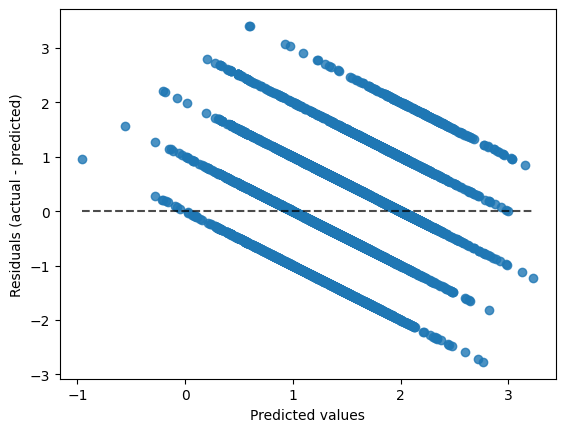

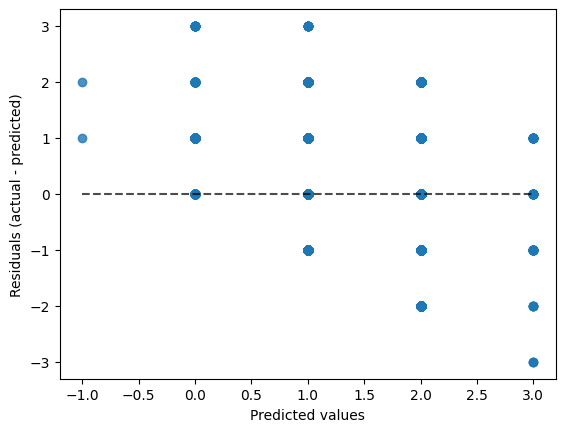

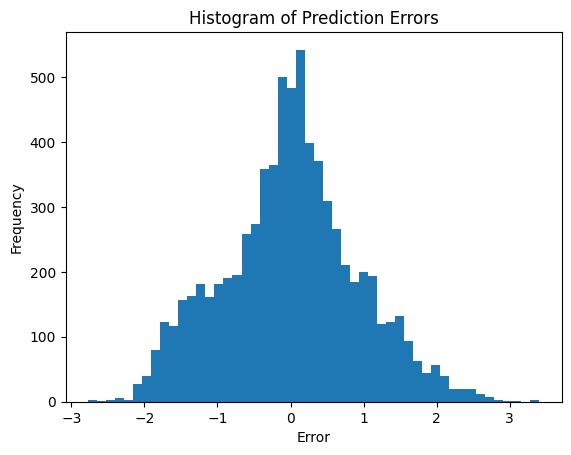

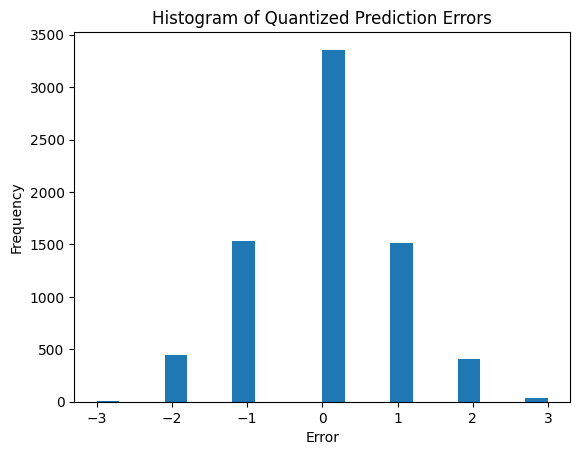

In [26]:
eval_model(linear_svr,y_test,X_test)

## SVR

In [27]:
sm_svr = SVR(C = 1.0, max_iter=1000000)
sm_svr.fit(sm_X_train, sm_y_train)

SVR(max_iter=1000000)

[[1.         0.89888275 1.        ]
 [1.         0.83728841 1.        ]
 [0.         1.8169214  2.        ]
 ...
 [2.         1.9869931  2.        ]
 [0.         1.77602219 2.        ]
 [2.         2.04167866 2.        ]]
Max error (cts): 3.864303136064217
RMS error (cts): 0.9427406505423137
Mean absolute error (cts): 0.7355765390701662
R2 score (cts): 0.1699136829294443
Max error (quantized): 4
RMS error (quantized): 0.9803404748026484
Mean absolute error (quantized): 0.6879302991531103
R2 score (quantized): 0.10237972430281106


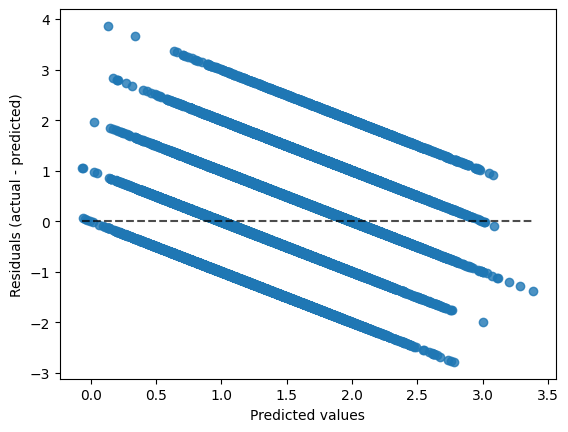

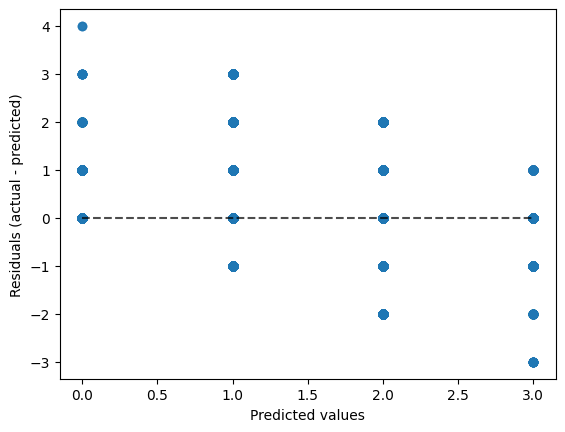

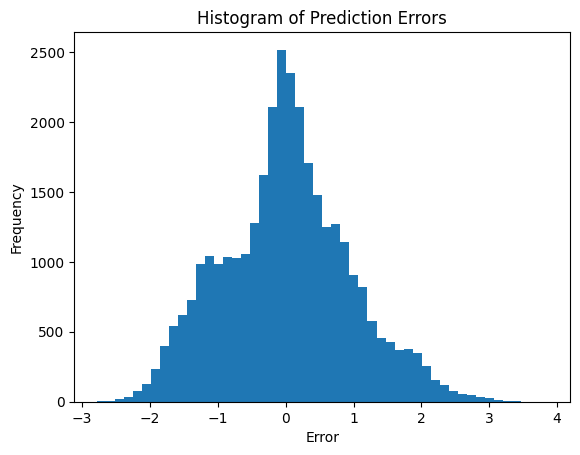

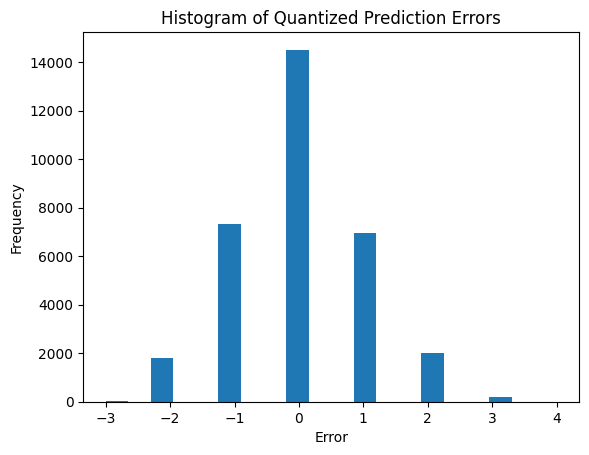

In [28]:
eval_model(sm_svr,sm_y_test,sm_X_test)

In [29]:
ssm_svr = SVR(C = 1.0, max_iter=1000000)
ssm_svr.fit(ssm_X_train, sm_y_train)

SVR(max_iter=1000000)

[[1.         0.90766176 1.        ]
 [1.         0.92334739 1.        ]
 [0.         1.69714853 2.        ]
 ...
 [2.         2.02299853 2.        ]
 [0.         0.92696818 1.        ]
 [2.         2.9001351  3.        ]]
Max error (cts): 3.0996786729220838
RMS error (cts): 0.9161239522249404
Mean absolute error (cts): 0.6946551638547774
R2 score (cts): 0.21612418921144882
Max error (quantized): 3
RMS error (quantized): 0.9418122406913269
Mean absolute error (quantized): 0.6666971303235241
R2 score (quantized): 0.17154781388756657


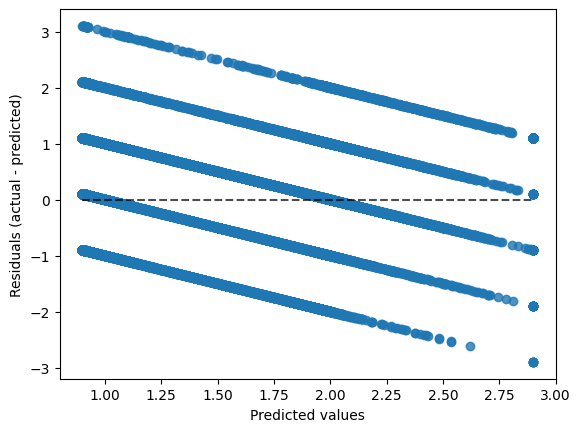

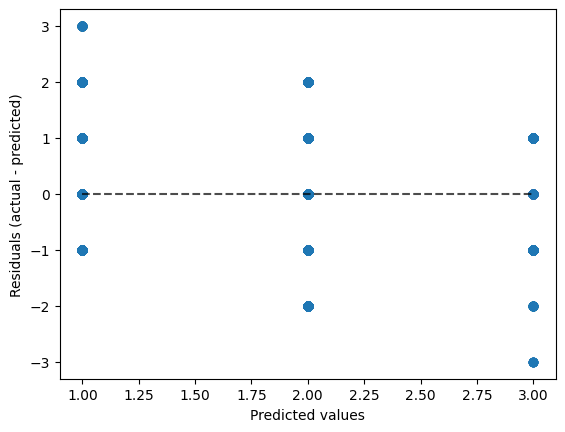

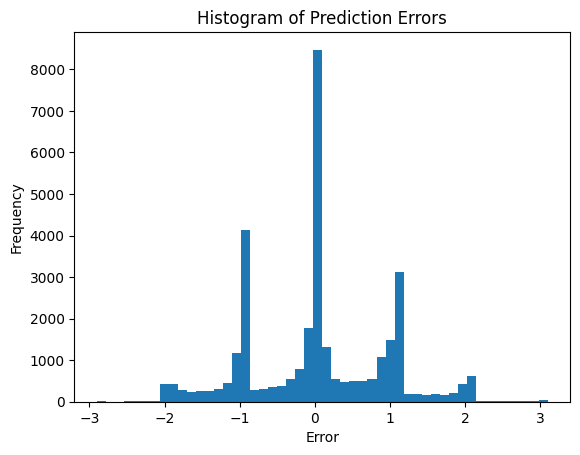

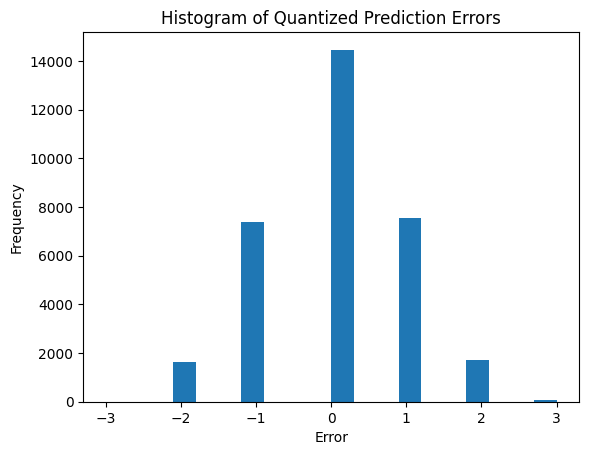

In [30]:
eval_model(ssm_svr,sm_y_test,ssm_X_test)

In [31]:
s_svr = SVR(C = 1.0, max_iter=1000000)
s_svr.fit(s_X_train, y_train)

SVR(max_iter=1000000)

[[1.         0.92338773 1.        ]
 [1.         1.01823107 1.        ]
 [0.         1.73253359 2.        ]
 ...
 [0.         1.17310119 1.        ]
 [3.         1.90222812 2.        ]
 [1.         0.90476213 1.        ]]
Max error (cts): 3.9000876575357624
RMS error (cts): 0.9067139204436584
Mean absolute error (cts): 0.6822435589585109
R2 score (cts): 0.2189956542636997
Max error (quantized): 4
RMS error (quantized): 0.9331309549182958
Mean absolute error (quantized): 0.6541466758053461
R2 score (quantized): 0.17282371091222426


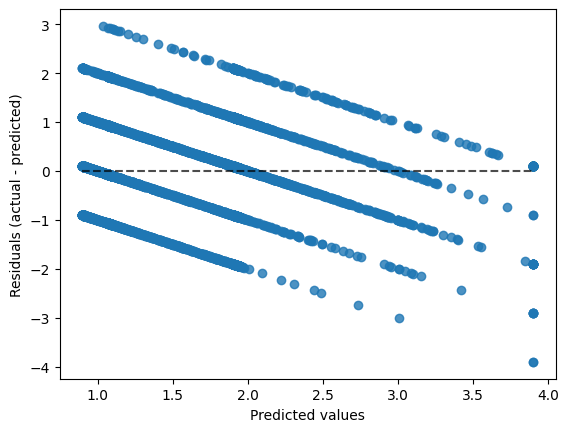

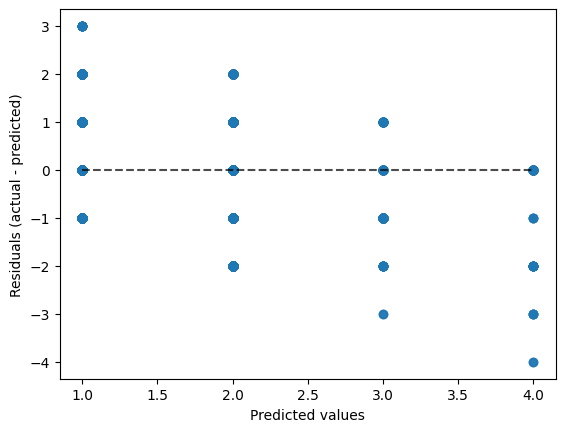

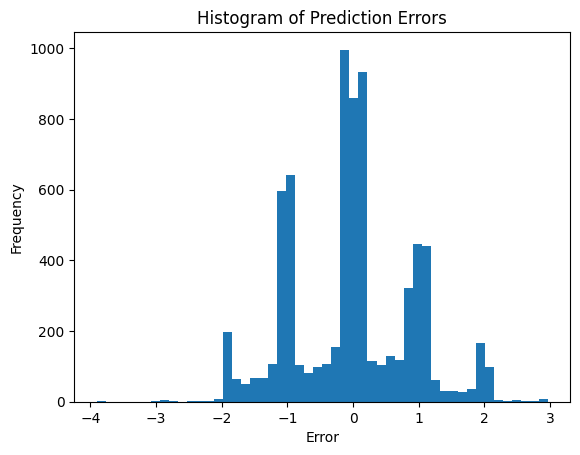

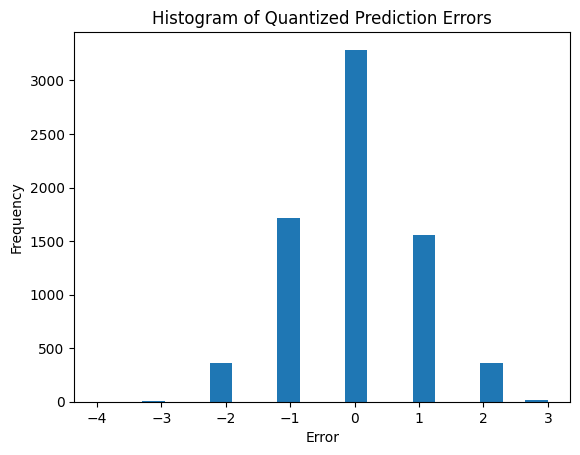

In [32]:
eval_model(s_svr,y_test,s_X_test)

## Decision Trees/Random Forest

In [33]:
rf = RandomForestRegressor(n_estimators = 10, criterion = 'friedman_mse', random_state = 0)
rf.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', n_estimators=10, random_state=0)

[[1.  0.9 1. ]
 [1.  0.8 1. ]
 [0.  1.2 1. ]
 ...
 [0.  1.4 1. ]
 [3.  2.1 2. ]
 [1.  0.9 1. ]]
Max error (cts): 3.486666666666666
RMS error (cts): 0.8386260408265536
Mean absolute error (cts): 0.6488684895842525
R2 score (cts): 0.33188753955051553
Max error (quantized): 3
RMS error (quantized): 0.8773284889865304
Mean absolute error (quantized): 0.596435915010281
R2 score (quantized): 0.26879803790493373


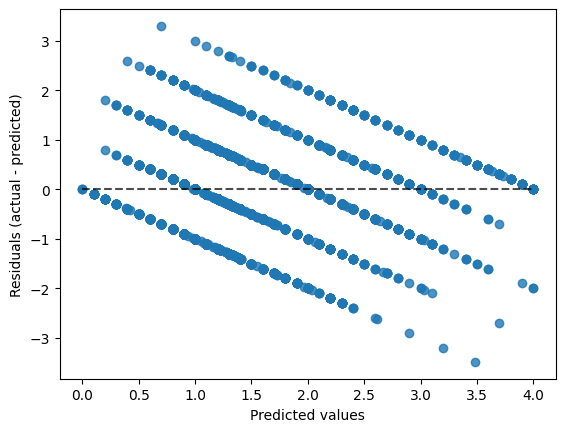

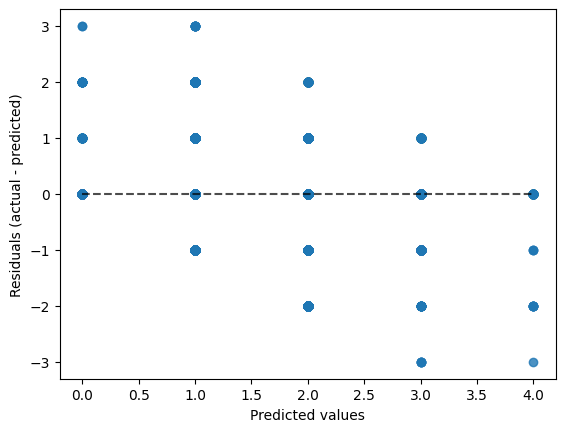

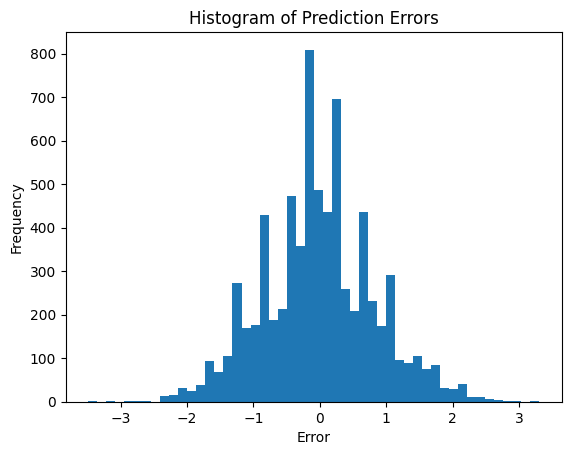

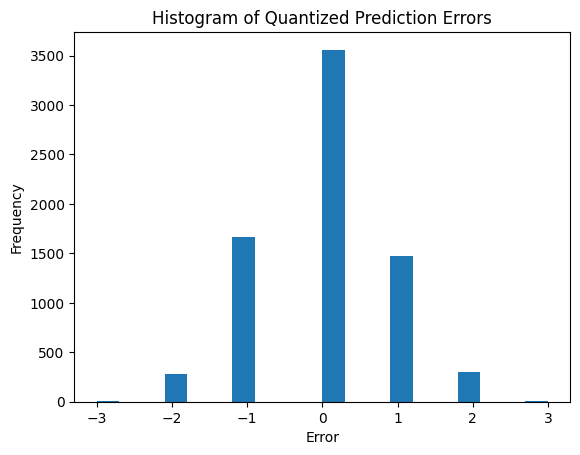

In [34]:
eval_model(rf,y_test,X_test)

In [35]:
s_rf = RandomForestRegressor(n_estimators = 100, criterion = 'friedman_mse', random_state = 0)
s_rf.fit(s_X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', random_state=0)

[[1.         1.         1.        ]
 [1.         0.93       1.        ]
 [0.         1.95328211 2.        ]
 ...
 [0.         1.32       1.        ]
 [3.         2.77       3.        ]
 [1.         1.01       1.        ]]
Max error (cts): 3.88
RMS error (cts): 1.0177119007554751
Mean absolute error (cts): 0.7910246668325374
R2 score (cts): 0.016073653476135208
Max error (quantized): 4
RMS error (quantized): 1.0691640287422732
Mean absolute error (quantized): 0.7655928718300206
R2 score (quantized): -0.08592932536255704


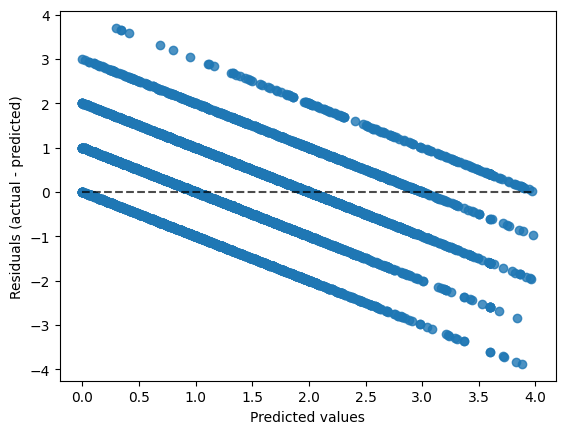

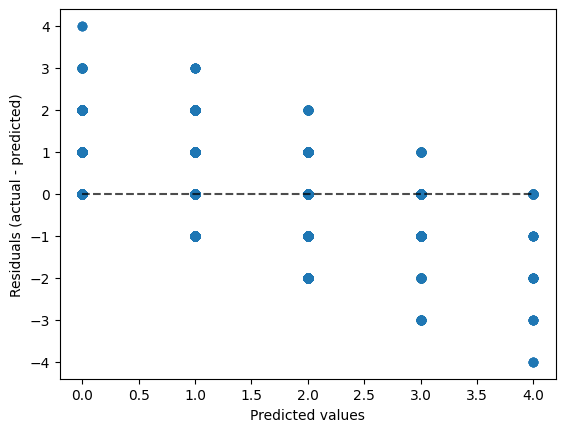

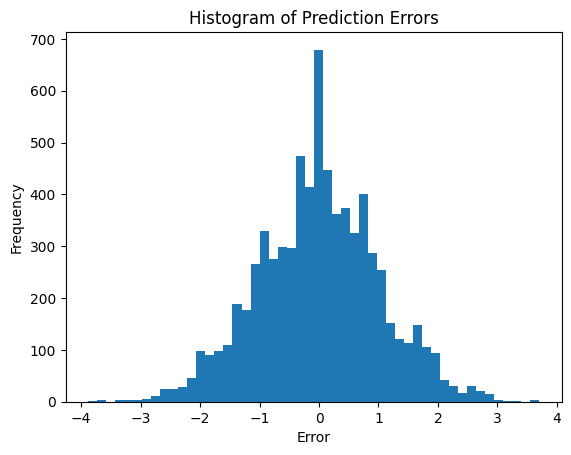

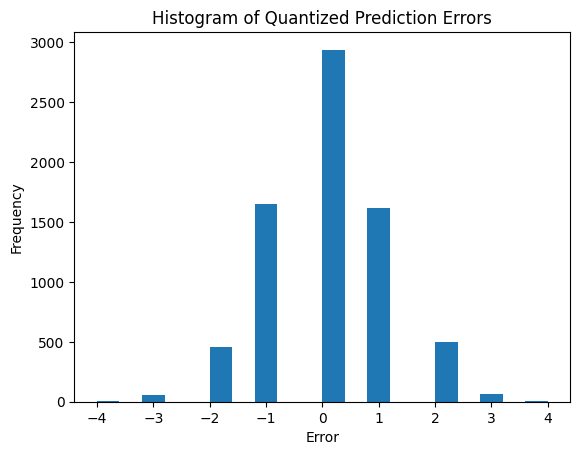

In [36]:
eval_model(s_rf,y_test,s_X_test)

In [37]:
ssm_rf = RandomForestRegressor(n_estimators = 500, criterion = 'friedman_mse', random_state = 0)
ssm_rf.fit(ssm_X_train, sm_y_train)

RandomForestRegressor(criterion='friedman_mse', n_estimators=500,
                      random_state=0)

[[1.         2.036      2.        ]
 [1.         0.908      1.        ]
 [0.         1.792      2.        ]
 ...
 [2.         2.27       2.        ]
 [0.         0.956      1.        ]
 [2.         3.58569649 4.        ]]
Max error (cts): 3.938
RMS error (cts): 1.0713612387226001
Mean absolute error (cts): 0.8490056346617968
R2 score (cts): -0.07203915203345268
Max error (quantized): 4
RMS error (quantized): 1.1231516223586198
Mean absolute error (quantized): 0.8288247121184427
R2 score (quantized): -0.17819063003502267


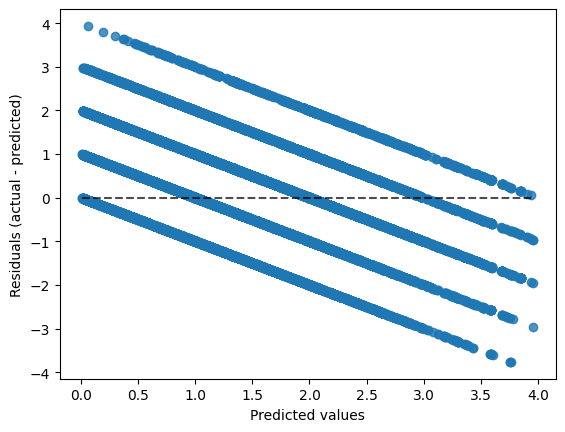

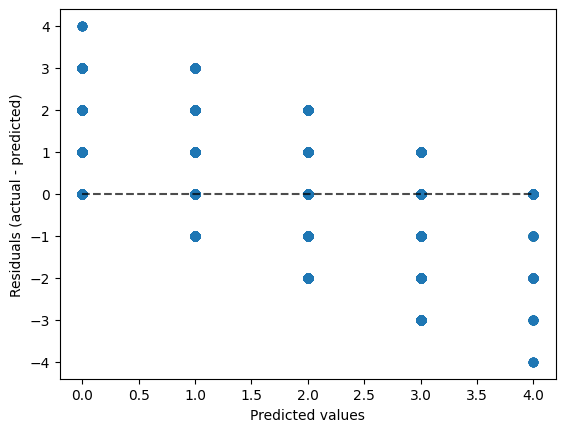

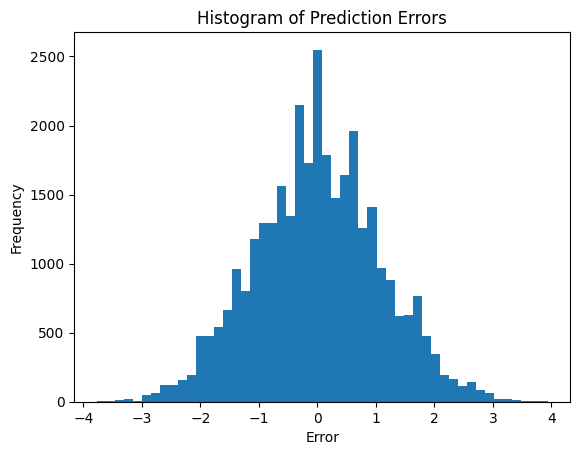

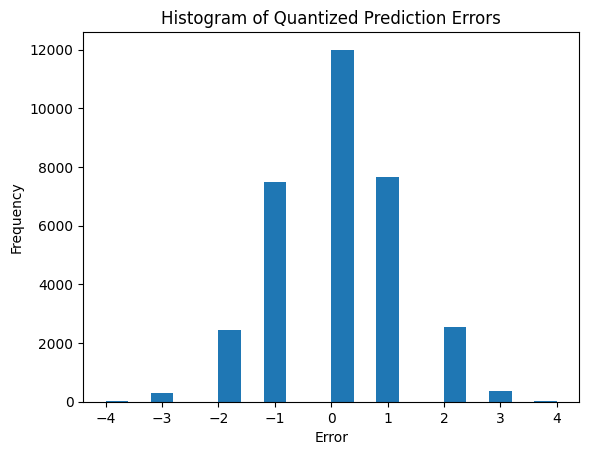

In [38]:
eval_model(ssm_rf,sm_y_test,ssm_X_test)

## Histogram Gradient Boosting

In [39]:
hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
hgb.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[1.         0.94021672 1.        ]
 [1.         0.68893144 1.        ]
 [0.         1.12318726 1.        ]
 ...
 [0.         0.74887234 1.        ]
 [3.         2.46718859 2.        ]
 [1.         0.74103997 1.        ]]
Max error (cts): 3.4741145754002365
RMS error (cts): 0.7855368801276955
Mean absolute error (cts): 0.6139370297340312
R2 score (cts): 0.41379969133312466
Max error (quantized): 3
RMS error (quantized): 0.8320186110640536
Mean absolute error (quantized): 0.561206305688828
R2 score (quantized): 0.34237401450043015


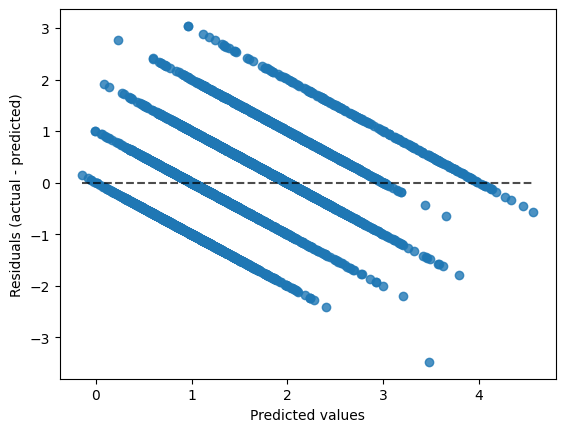

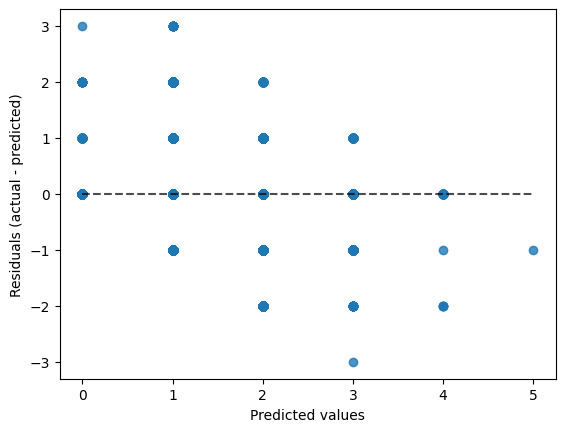

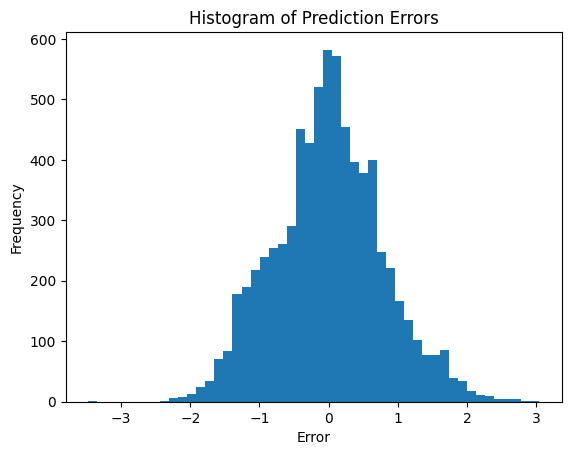

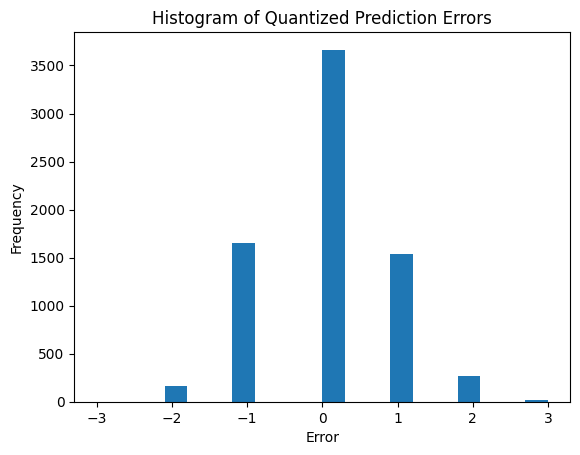

In [40]:
eval_model(hgb,y_test,X_test)

In [41]:
s_hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
s_hgb.fit(s_X_train, y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[1.         0.94797206 1.        ]
 [1.         1.00877711 1.        ]
 [0.         1.45218535 1.        ]
 ...
 [0.         1.29587636 1.        ]
 [3.         2.0926097  2.        ]
 [1.         0.99924997 1.        ]]
Max error (cts): 2.9708234087600225
RMS error (cts): 0.8934667814734389
Mean absolute error (cts): 0.6963898782031419
R2 score (cts): 0.2416499767164283
Max error (quantized): 3
RMS error (quantized): 0.9246454222872786
Mean absolute error (quantized): 0.6534612748457848
R2 score (quantized): 0.18779935216617483


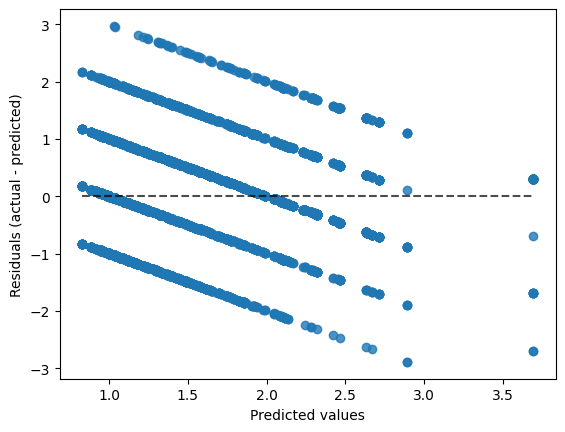

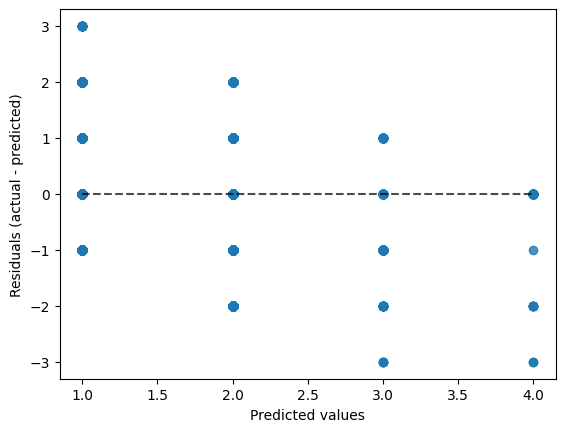

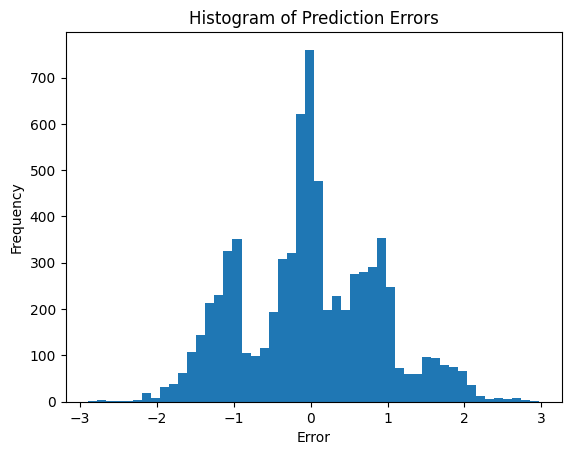

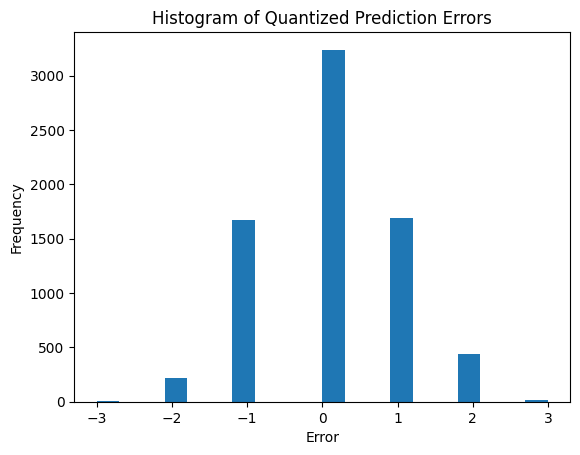

In [42]:
eval_model(s_hgb,y_test,s_X_test)

In [43]:
ssm_hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
ssm_hgb.fit(ssm_X_train, sm_y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[1.         1.12060411 1.        ]
 [1.         1.12374021 1.        ]
 [0.         1.14929446 1.        ]
 ...
 [2.         1.93926494 2.        ]
 [0.         0.90523627 1.        ]
 [2.         3.68854458 4.        ]]
Max error (cts): 3.6885445806978328
RMS error (cts): 0.9244086266048175
Mean absolute error (cts): 0.7294528902046477
R2 score (cts): 0.20188262344300922
Max error (quantized): 4
RMS error (quantized): 0.9543756474148324
Mean absolute error (quantized): 0.6844269786145128
R2 score (quantized): 0.14929793891624665


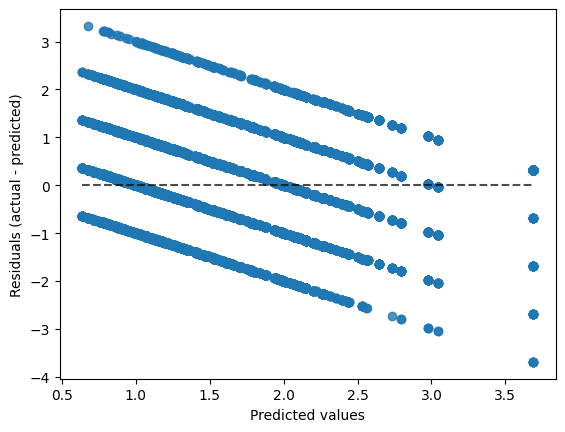

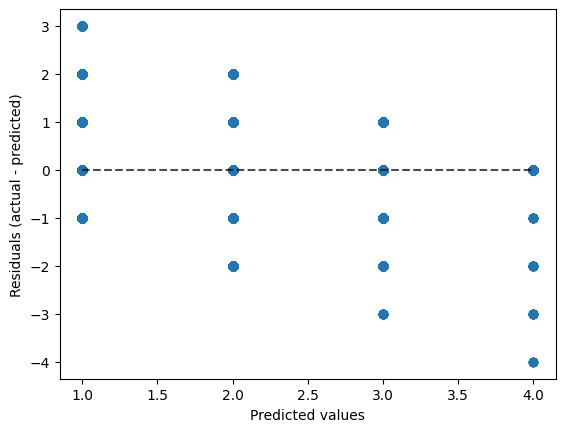

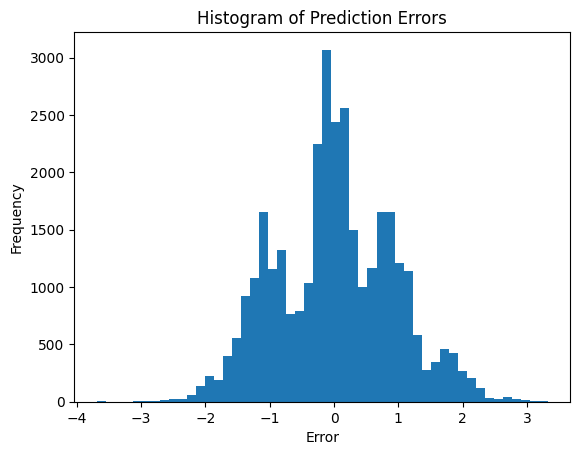

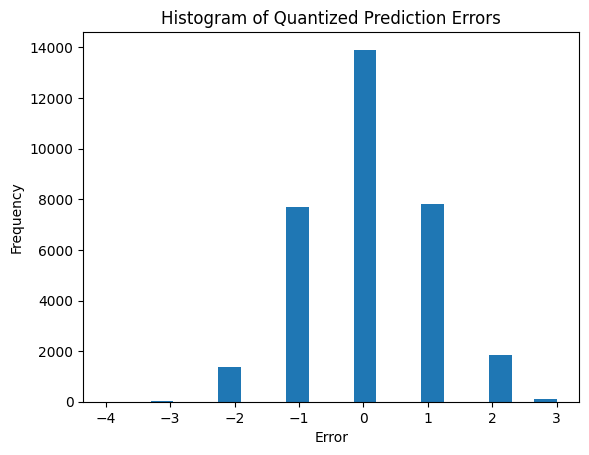

In [44]:
eval_model(ssm_hgb,sm_y_test,ssm_X_test)